<a href="https://colab.research.google.com/github/020/020.github.io/blob/master/120922_Exp_2_Bed_Occupancy_Forecasting_diff_split_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [119]:
df = pd.read_csv('/content/beds_occupied.csv')

date_time = pd.to_datetime(df.pop('date'), format='%d/%m/%Y %H:%M')

timestamp_s = date_time.map(pd.Timestamp.timestamp)




In [120]:
df.head()

,occupied
0,0.79
1,0.79
2,0.80
3,0.80
4,0.80


In [121]:
df.shape

(2000, 1)

In [122]:
df_train = df[:1900]
df_train.shape

(1900, 1)

In [123]:
df_test = df[1900:]
df_test.shape

(100, 1)

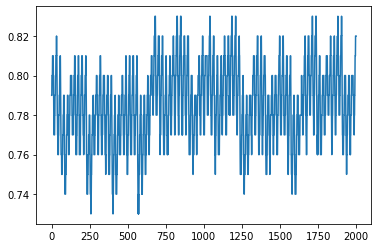

In [124]:
bed = df['occupied']
bed.plot()

In [125]:
from sklearn.preprocessing import RobustScaler

data = df_train.copy()

# Get the number of rows in the data
nrows = data.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data)
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

In [126]:
window_size = 60

# Split the data into train and test sets, for both unscaled and scaled data
split_time = 1700
unscaled_train_data = data[0:split_time]
unscaled_test_data = data[split_time:]
unscaled_series = data

scaled_train_data = np_data_scaled[0:split_time]
scaled_test_data = np_data_scaled[split_time - window_size:]
scaled_series = np_data_scaled

In [127]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(1).prefetch(1)
  return dataset

scaled_train_dataset = windowed_dataset(scaled_train_data, window_size, 1, 1)

In [128]:
#DNN
tf.keras.backend.clear_session()

dnn_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size]),   
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)           
])

dnn_model.compile(optimizer="adam", loss="mean_squared_error")
dnn_history = dnn_model.fit(scaled_train_dataset, epochs=10, batch_size=1)

Epoch 1/10
1640/1640 [==============================] - 5s 3ms/step - loss: 0.1615
Epoch 2/10
1640/1640 [==============================] - 4s 3ms/step - loss: 0.0589
Epoch 3/10
1640/1640 [==============================] - 4s 3ms/step - loss: 0.0466
Epoch 4/10
1640/1640 [==============================] - 4s 3ms/step - loss: 0.0450
Epoch 5/10
1640/1640 [==============================] - 4s 3ms/step - loss: 0.0494
Epoch 6/10
1640/1640 [==============================] - 4s 3ms/step - loss: 0.0417
Epoch 7/10
1640/1640 [==============================] - 4s 3ms/step - loss: 0.0400
Epoch 8/10
1640/1640 [==============================] - 4s 3ms/step - loss: 0.0396
Epoch 9/10
1640/1640 [==============================] - 4s 3ms/step - loss: 0.0367
Epoch 10/10
1640/1640 [==============================] - 6s 3ms/step - loss: 0.0352


In [129]:
#LSTM
tf.keras.backend.clear_session()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(window_size, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.LSTM(window_size, return_sequences=False),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mean_squared_error")
lstm_history = lstm_model.fit(scaled_train_dataset, batch_size=1, epochs=8)

Epoch 1/8
1640/1640 [==============================] - 15s 7ms/step - loss: 0.2160
Epoch 2/8
1640/1640 [==============================] - 12s 7ms/step - loss: 0.0520
Epoch 3/8
1640/1640 [==============================] - 13s 8ms/step - loss: 0.0484
Epoch 4/8
1640/1640 [==============================] - 12s 7ms/step - loss: 0.0481
Epoch 5/8
1640/1640 [==============================] - 12s 7ms/step - loss: 0.0526
Epoch 6/8
1640/1640 [==============================] - 12s 7ms/step - loss: 0.0859
Epoch 7/8
1640/1640 [==============================] - 12s 8ms/step - loss: 0.0540
Epoch 8/8
1640/1640 [==============================] - 12s 7ms/step - loss: 0.0402


In [130]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
steps_without_test = 1900 #train test split
def get_unscaled_forecast(model, scaled_series, window_size):
  forecast = []
  scaled_forecast = []
  for time in range(steps_without_test - window_size):
    scaled_forecast.append(model.predict(scaled_series[time:time + window_size][np.newaxis]))
  scaled_forecast = np.array(scaled_forecast).squeeze().reshape(-1, 1)
  unscaled_forecast = scaler.inverse_transform(scaled_forecast)
  return unscaled_forecast

In [131]:
dnn_forecast = get_unscaled_forecast(dnn_model, scaled_series, window_size)
dnn_forecast = dnn_forecast[split_time-window_size:]
dnn_results = np.array(dnn_forecast)[:, 0]

In [132]:
lstm_forecast = get_unscaled_forecast(lstm_model, scaled_series, window_size)
lstm_forecast = lstm_forecast[split_time-window_size:]
lstm_results = np.array(lstm_forecast)[:, 0]

In [133]:
print("DNN MAE: {}".format(round(mean_absolute_error(unscaled_test_data, dnn_results), 4)))
print("LSTM MAE: {}".format(round(mean_absolute_error(unscaled_test_data, lstm_results), 4)))

DNN MAE: 0.0047
LSTM MAE: 0.0047


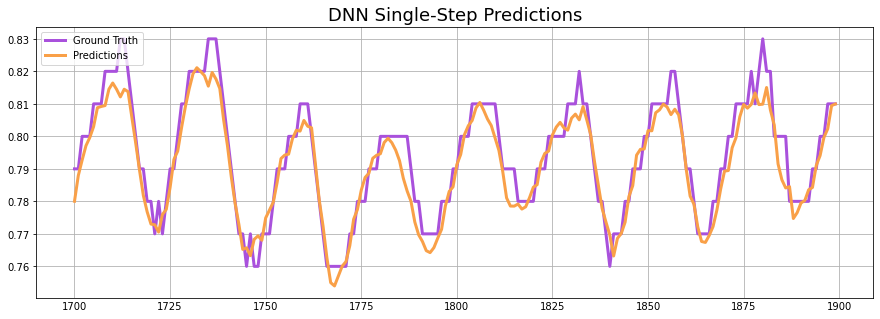

In [134]:
# Visualize the data
df_dnn = df_train.copy()
df_dnn_valid_pred = df_dnn[split_time:]
df_dnn_valid_pred.insert(1, "Predictions", dnn_results, True)
fig, ax1 = plt.subplots(figsize=(15, 5), sharex=True)

ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("DNN Single-Step Predictions", fontsize=18)
plt.plot(df_dnn_valid_pred["occupied"], color="#A951DC", linewidth=3.0)
plt.plot(df_dnn_valid_pred["Predictions"], color="#F9A048", linewidth=3.0)
plt.legend(["Ground Truth", "Predictions"], loc="upper left")
plt.grid()
plt.show()

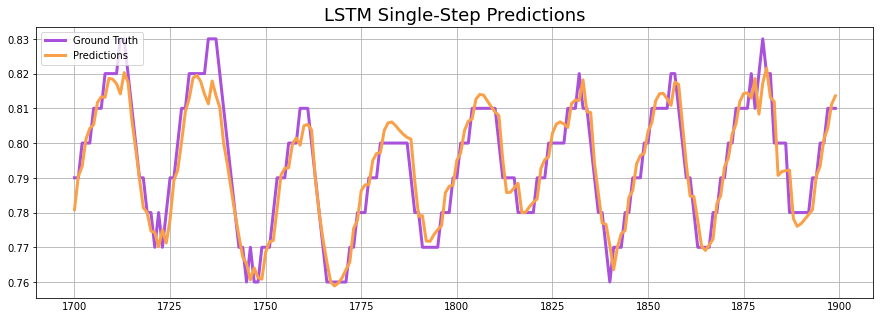

In [135]:
# Visualize the data
df_lstm = df_train.copy()
df_lstm_valid_pred = df_lstm[split_time:]
df_lstm_valid_pred.insert(1, "Predictions", lstm_results, True)
fig, ax1 = plt.subplots(figsize=(15, 5), sharex=True)

ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("LSTM Single-Step Predictions", fontsize=18)
plt.plot(df_lstm_valid_pred["occupied"], color="#A951DC", linewidth=3.0)
plt.plot(df_lstm_valid_pred["Predictions"], color="#F9A048", linewidth=3.0)
plt.legend(["Ground Truth", "Predictions"], loc="upper left")
plt.grid()
plt.show()

In [137]:
def make_multi_step_forecast(model, scaled_series, window_size, df):
  new_df = df.filter(["occupied"])
  rolling_forecast_range = 100
  test_series = scaled_series[-window_size:]
  for time in range(0, rolling_forecast_range):
    prediction = model.predict(test_series[-window_size:][np.newaxis])
    prediction_unscaled = scaler.inverse_transform(prediction)
    test_series = np.append(test_series, prediction)
    new_df = new_df.append(pd.DataFrame({"occupied": prediction_unscaled[0, 0]}, index=new_df.iloc[[-1]].index.values + 1))
  forecast = new_df[new_df.size - rolling_forecast_range : new_df.size].rename(columns={"occupied": "Forecast"})
  return forecast

def plot_forecast(forecast, df_valid_pred):
  #Visualize the results
  df_multistep = df_valid_pred.copy();
  dflen = forecast.size - 1
  df_multistep = pd.concat([df_multistep, forecast], sort=False)

  plt.figure(figsize=(15, 5))
  plt.title('DNN Forecast', fontsize=18)
  plt.plot(df_multistep["occupied"], color="#039dfc", linewidth=1.5)
  plt.plot(df_multistep["Predictions"], color="#F9A048", linewidth=1.5)
  plt.scatter(forecast.index, forecast, color="#F332E6", linewidth=1.0)
  plt.plot(forecast, color="#F332E6", linewidth=0.5)  
  plt.legend(["Ground Truth", "Single-Step Forecast", "Multi-Step Forecast"], loc="upper left")
  plt.grid()
  plt.show()

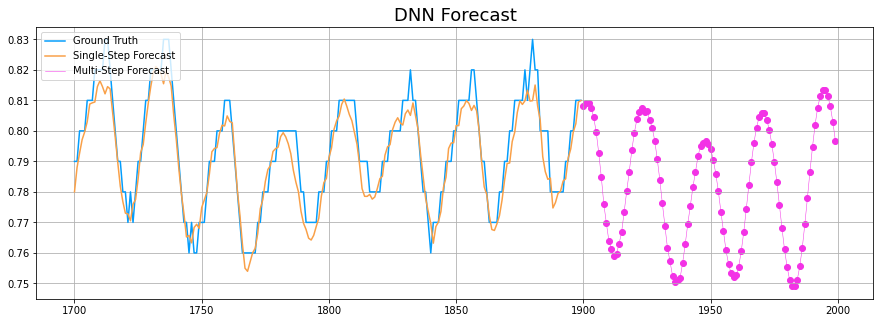

In [138]:
dnn_multistep_forecast = make_multi_step_forecast(dnn_model, scaled_series, window_size, df_dnn)
plot_forecast(dnn_multistep_forecast, df_dnn_valid_pred)

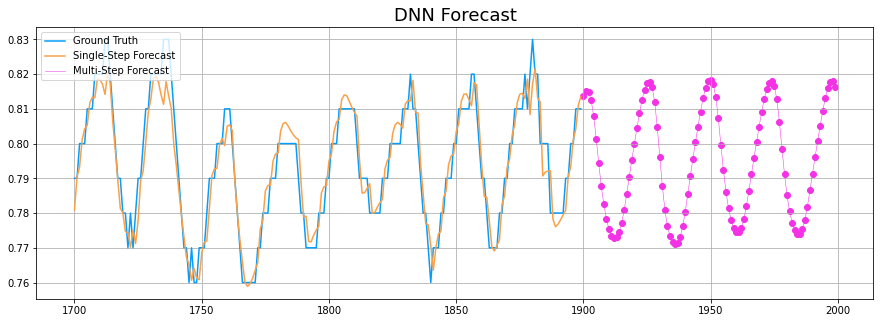

In [139]:
lstm_multistep_forecast = make_multi_step_forecast(lstm_model, scaled_series, window_size, df_lstm)
plot_forecast(lstm_multistep_forecast, df_lstm_valid_pred)

In [140]:
def plot_forecast_against_test(forecast, df_test):
  #Visualize the results
  df_test_forecast = df_test.copy();
  df_test_forecast.insert(1, "Predictions", forecast, True)

  plt.figure(figsize=(16, 5))
  plt.title('DNN Forecast', fontsize=18)
  plt.plot(df_test_forecast["occupied"], color="#039dfc", linewidth=1.5)
  plt.plot(df_test_forecast["Predictions"], color="#F332E6", linewidth=1.5)
  plt.legend(["Ground Truth", "Multi-Step Forecast"], loc="upper left")
  plt.grid()
  plt.show()

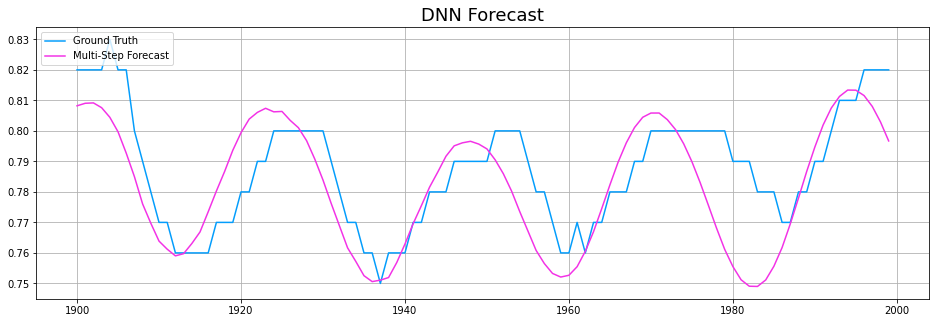

In [141]:
plot_forecast_against_test(dnn_multistep_forecast, df_test)

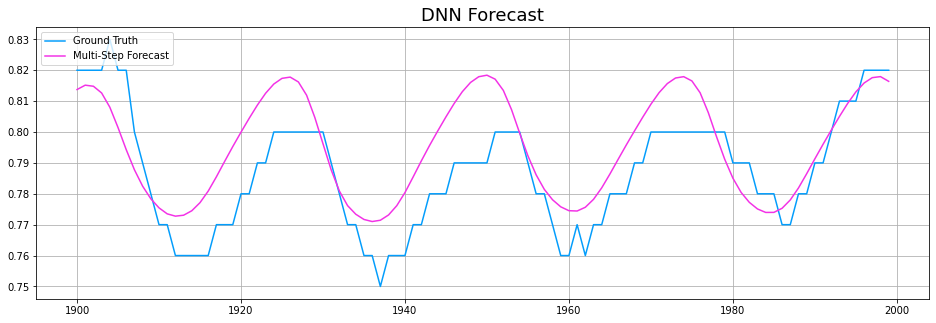

In [142]:
plot_forecast_against_test(lstm_multistep_forecast, df_test)

In [143]:
print("DNN MAE: {}".format(round(mean_absolute_error(df_test, dnn_multistep_forecast), 4)))
print("LSTM MAE: {}".format(round(mean_absolute_error(df_test, lstm_multistep_forecast), 4)))

DNN MAE: 0.012
LSTM MAE: 0.0116
